In [111]:
%matplotlib inline

import os
import sys

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as plt
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone

from binance_utility.plot_utils import plot_correlation

import backtrader as bt
import random

In [7]:
# 約定履歴21日分を読み込む。あらかじめdownload_trades.pyを使ってデータファイルをダウンロードしておくこと。
days = 21
symbol = "BTCUSDT"

# 指定日から30日前までのデータを使いたい場合
last_date = date(year=2023, month=5, day=5)
# 昨日から30日前までのデータを使いたい場合
# last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)

if "df_trades" in globals():
    del df_trades
df_trades = None
date_cursor = start_date

while date_cursor <= last_date:
    if df_trades is None:
        df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_trades = df_trades.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")]).sort("timestamp")
df_trades.describe()

describe,symbol,timestamp,first_update_id,last_update_id,side,update_type,price,qty,pu
str,str,f64,f64,f64,str,str,f64,f64,f64
"""count""","""105395638""",1.05395638e8,1.05395638e8,1.05395638e8,"""105395638""","""105395638""",1.05395638e8,1.05395638e8,1.05395638e8
"""null_count""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0
"""mean""",null,1.6825e12,3.6179e9,3.6179e9,null,null,28841.967875,-0.000676,3.6179e9
"""std""",null,5.2480e8,3.0430e7,3.0430e7,null,null,909.584867,0.629621,3.0430e7
"""min""","""BTCUSDT""",1.6814e12,3.5652e9,3.5652e9,"""a""","""trade""",26919.3,-767.221,3.5652e9
"""max""","""BTCUSDT""",1.6833e12,3.6706e9,3.6706e9,"""b""","""trade""",31059.0,861.647,3.6706e9
"""median""",null,1.6825e12,3.6179e9,3.6179e9,null,null,28901.6,-0.001,3.6179e9
"""25%""",null,1.6820e12,3.5916e9,3.5916e9,null,null,28169.1,-0.009,3.5916e9
"""75%""",null,1.6829e12,3.6443e9,3.6443e9,null,null,29405.2,0.009,3.6443e9


In [152]:
# タイムバーを作成
groupby_interval_min = 15
groupby_interval = groupby_interval_min * 60 * 1000

df_timebar = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval)}i", closed="left").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"), pl.col("price").last().alias("close"), np.abs(pl.col("qty")).sum().alias("volume"), pl.col("qty").sum().alias("qty_sum"), (pl.col("price").std() / np.sqrt(60)).alias("real_sigma")])
df_timebar = df_timebar.with_columns([((pl.col("close") - pl.col("open")) / pl.col("open")).alias("pct_change_price"), (pl.col("close") - pl.col("open")).alias("delta_price")])
df_timebar

argument is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


timestamp,open,high,low,close,volume,qty_sum,real_sigma,pct_change_price,delta_price
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1681430400000,30362.7,30370.3,30334.1,30347.1,2340.601,-453.929,1.396502,-0.000514,-15.6
1681431300000,30347.2,30409.8,30293.0,30386.7,4043.53,416.412,3.870848,0.001302,39.5
1681432200000,30386.8,30822.8,30364.7,30721.9,42852.661,6622.333,15.667075,0.011028,335.1
1681433100000,30721.9,30768.1,30641.8,30741.3,12533.362,-1036.196,3.668081,0.000631,19.4
1681434000000,30741.4,30850.0,30704.9,30814.9,12591.341,1012.045,4.14972,0.002391,73.5
1681434900000,30814.8,30830.0,30681.0,30770.9,8806.14,-887.758,4.66199,-0.001425,-43.9
1681435800000,30770.8,30835.4,30722.2,30817.8,8496.297,708.077,3.557195,0.001527,47.0
1681436700000,30817.7,30950.0,30750.0,30776.4,12891.74,613.714,5.799078,-0.00134,-41.3
1681437600000,30776.3,30811.7,30711.1,30805.4,6661.243,239.439,2.831342,0.000946,29.1


In [158]:
df_timebar_pd = df_timebar.to_pandas()
df_timebar_pd = df_timebar_pd[["timestamp", "open", "high", "low", "close", "volume"]]
df_timebar_pd["datetime"] = pd.to_datetime(df_timebar_pd["timestamp"], unit="ms")
df_timebar_pd = df_timebar_pd.drop("timestamp", axis=1).set_index("datetime", drop=True)
df_timebar_pd_filtered = df_timebar_pd[(df_timebar_pd.index >= "2023-04-28") & (df_timebar_pd.index <= "2023-05-01")]
df_timebar_pd_filtered

,open,high,low,close,volume
datetime,,,,,
2023-04-28 00:00:00,29459.0,29520.0,29408.0,29412.8,5408.732
2023-04-28 00:15:00,29412.8,29463.1,29350.0,29375.0,4627.425
2023-04-28 00:30:00,29375.1,29448.1,29336.5,29399.2,4518.213
2023-04-28 00:45:00,29399.2,29555.2,29399.1,29539.6,9916.153
2023-04-28 01:00:00,29539.6,29591.1,29452.7,29465.6,11211.791
...,...,...,...,...,...
2023-04-30 23:00:00,29363.2,29410.9,29310.8,29380.5,2818.304
2023-04-30 23:15:00,29380.5,29380.5,29310.3,29378.4,2057.341
2023-04-30 23:30:00,29378.4,29405.8,29348.9,29378.6,2098.089


2023-04-28T00:00:00, Starting next()
3.39 3.39
2023-04-28T00:00:00, 2023-04-28T00:00:00.000 value=100000.000000 cash=100000.000000 close=29412.800000 bid_price=29438.160000, ask_price=29492.420000 bid_ask_gap=159.244183 q=0.000000 bid_ask_skew=0.000000
2023-04-28T00:00:00, end of next()
2023-04-28T00:15:00, Starting next()
2023-04-28T00:15:00, cancel 6512396972643433786
2.39 2.39
2023-04-28T00:15:00, 2023-04-28T00:15:00.000 value=99962.200000 cash=70587.200000 close=29375.000000 bid_price=29513.860000, ask_price=29346.800000 bid_ask_gap=164.923675 q=1.000000 bid_ask_skew=221.323034
2023-04-28T00:15:00, end of next()
2023-04-28T00:30:00, Starting next()
3.39 3.39
2023-04-28T00:30:00, 2023-04-28T00:30:00.000 value=99962.300000 cash=99962.300000 close=29399.200000 bid_price=29430.130000, ask_price=29484.390000 bid_ask_gap=170.385617 q=0.000000 bid_ask_skew=0.000000
2023-04-28T00:30:00, end of next()
2023-04-28T00:45:00, Starting next()
3.38 3.38
2023-04-28T00:45:00, 2023-04-28T00:45:00.00

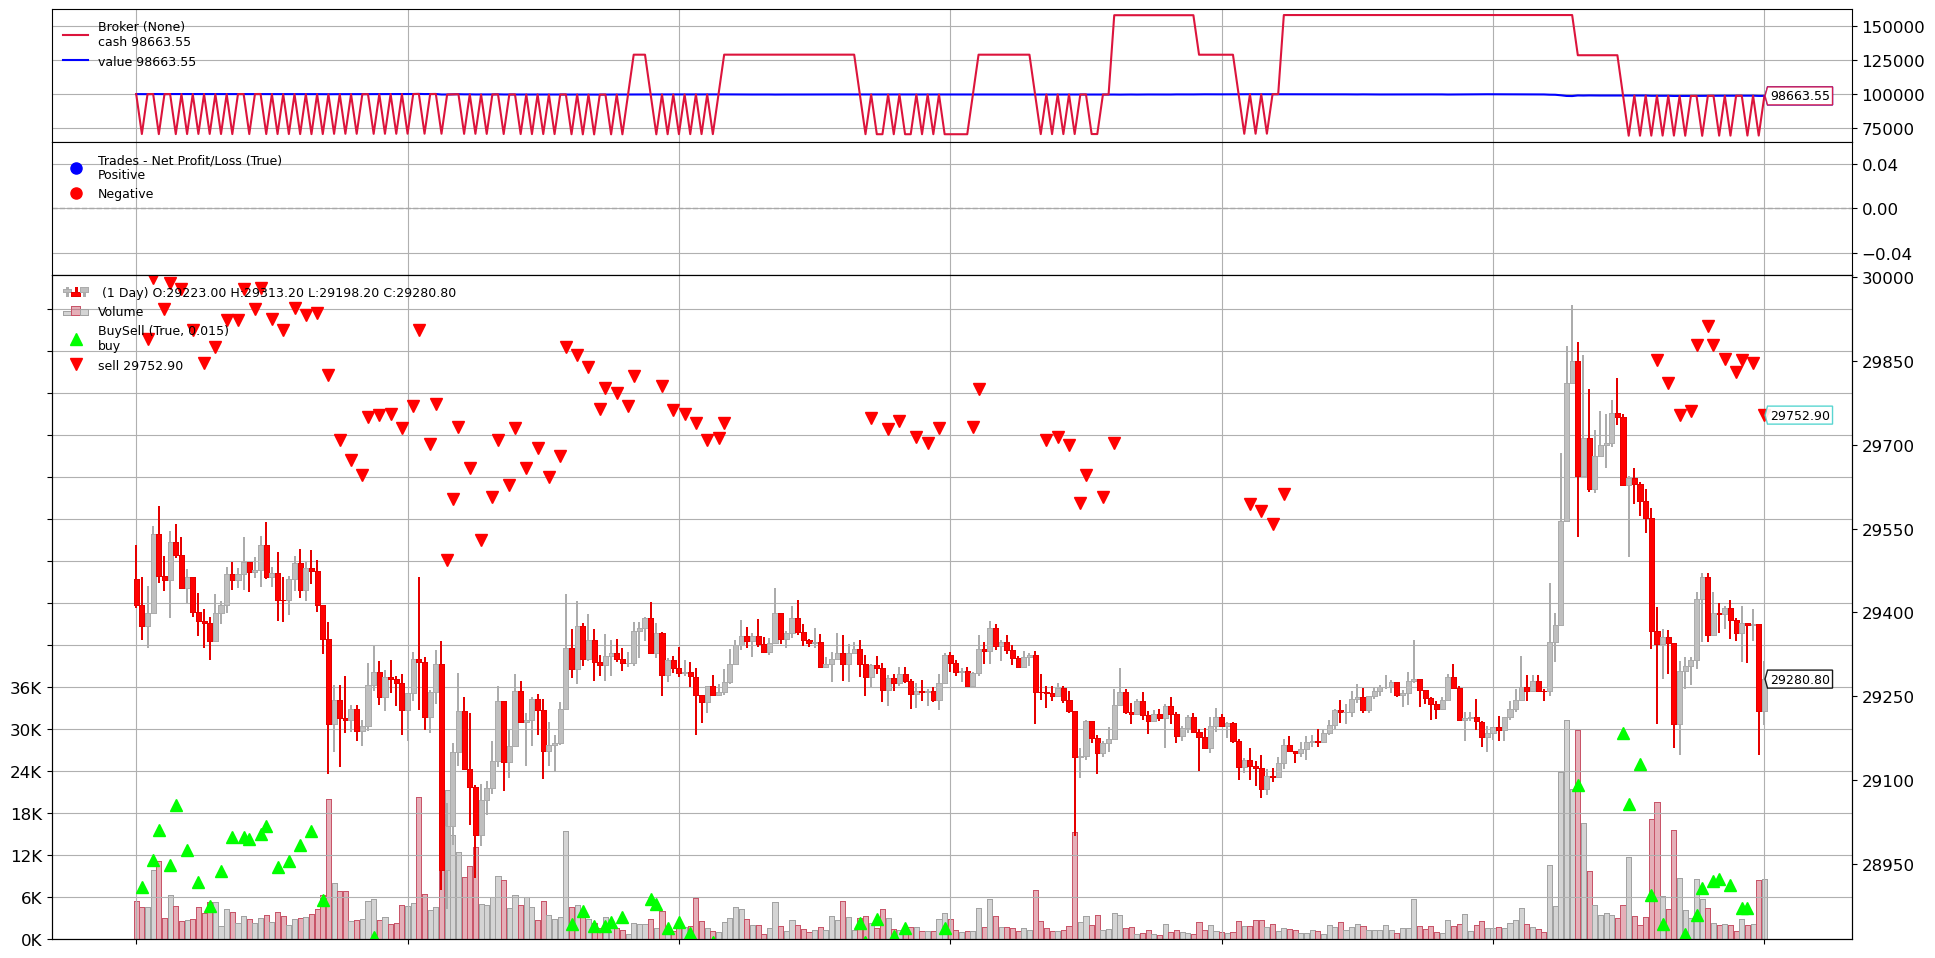

[[<Figure size 2000x1000 with 4 Axes>]]

In [160]:
class SmaCross(bt.SignalStrategy):
    params = (
        ("position_abs_max", 1),
        ("s_lambda", 1 / (groupby_interval_min * 60)),
        ("l_delta", 1),
        ("s_a", 226.98638124), # 15min
        #("s_a", 3.48810636), # 30min
        ("s_alpha", 1.1254549), # 15min
        #("s_alpha", 0.51498774), # 30min
         ("s_b", 3.0534806e+01), # 15min
        #("s_b", 4.03818568e+01), # 1h
        ("s_c", 1.2302710e-02), #15min
        #("s_c", 9.42896406e-03), #1h
        ("s_gamma", 1),
        ("printout", True),
        ('period', 3)
    )

    def __init__(self):
        self.l_a = self.params.s_lambda / self.params.s_alpha * self.params.s_a / self.params.s_c
        self.s_k = self.params.s_alpha / self.params.s_b
        self.order_list = []
        self.previous_order_trade_id_list = []
    
    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print(f"{dt.isoformat()}, {txt}")
            
    def notify_trade(self, trade):
        if trade.isclosed:
            self.log(f"profit {trade.pnlcomm}")

    def notify_order(self, order):
        _status = order.status
        if _status == order.Completed:
            if order in self.order_list:
                self.order_list.remove(order)
            #self.log(f"{bt.num2date(order.executed.dt)} ID : {order.tradeid} {'BUY' if order.isbuy() else 'SELL'} completed {order.executed.size:.02f}@{order.executed.price:.02f}")
            pass
        elif _status == order.Submitted:
            #self.log(f"{bt.num2date(order.created.dt)} ID : {order.tradeid} {'BUY' if order.isbuy() else 'SELL'} submitted {order.created.size}@{order.created.price}")
            pass
        elif _status == order.Accepted:
            if order not in self.order_list:
                self.order_list.append(order)
            #self.log(f"{bt.num2date(order.created.dt)} ID : {order.tradeid} {'BUY' if order.isbuy() else 'SELL'} accepted {order.created.size:.02f}@{order.created.price:.02f}")
            pass
        elif _status == order.Canceled:
            if order in self.order_list:
                self.order_list.remove(order)
            #self.log(f"{bt.num2date(order.created.dt)} ID : {order.tradeid} {'BUY' if order.isbuy() else 'SELL'} canceled {order.created.size}@{order.created.price}")
            pass
    
    def OK_Estimator(self, open, high, low, close, duration_sec):
        return (0.811 * (high - low) - 0.369 * np.abs(close - open)) / np.sqrt(duration_sec)
    
    def next(self):        
        # Acceptedされていた全てのオーダーをキャンセル
        if len(self.order_list) > 0:
            for _order in self.order_list:
                self.log(f"cancel {_order.tradeid}")
                self.broker.cancel(_order)
                self.order_list.remove(_order)

        # ポジションサイズを確認
        _q = self.getposition().size

        # OHLCVバーの情報を取得
        _open = self.data.open[0]
        _high = self.data.high[0]
        _low = self.data.low[0]
        _close = self.data.close[0]
        _volume = self.data.volume[0]

        # 指値計算
        _est_sigma = self.OK_Estimator(_open, _high, _low, _close, 1)
        _delta = self.params.l_delta
        _gamma = self.params.s_gamma
        _k = self.s_k
        _A = self.l_a

        _bid_ask_gap = 2 / _k + _delta * np.sqrt((_gamma * _est_sigma ** 2 * np.e) / (2 * _A * _delta * _k))
        _bid_ask_skew = 2 * _q * np.sqrt((_gamma * _est_sigma ** 2 * np.e) / (2 * _A * _delta * _k))

        _bid_price = self.data.close[0] - 1 / _k + (2 * _q + _delta) / 2 * np.sqrt((_gamma * _est_sigma ** 2 * np.e) / (2 * _A * _delta * _k))
        _bid_price = np.round(_bid_price, 2)
        _ask_price = self.data.close[0] + 1 / _k - (2 * _q - _delta) / 2 * np.sqrt((_gamma * _est_sigma ** 2 * np.e) / (2 * _A * _delta * _k))
        _ask_price = np.round(_ask_price, 2)

        # オーダーサイズの決定
        _available_cash = self.broker.get_cash()
        _max_bid_size = np.floor(_available_cash / _bid_price * 100) / 100
        _max_ask_size = np.floor(_available_cash / _bid_price * 100) / 100
        print(_max_bid_size, _max_ask_size)

        if _q < self.params.position_abs_max:
            _size = _delta            
            _trade_id = random.randint(1, sys.maxsize)
            _bid_order = self.buy(exectype=bt.Order.Limit, price=_bid_price, size=_size, tradeid=_trade_id)
            self.broker.submit(_bid_order)
        if _q > -self.params.position_abs_max:
            _size = _delta
            _trade_id = random.randint(1, sys.maxsize)
            _ask_order = self.sell(exectype=bt.Order.Limit, price=_ask_price, size=_size, tradeid=_trade_id)
            self.broker.submit(_ask_order)
        
        self.log(f"{bt.num2date(self.data.datetime[0]).isoformat(timespec='milliseconds')} value={self.broker.get_value():02f} cash={self.broker.get_cash():02f} close={self.data.close[0]:02f} bid_price={_bid_price:02f}, ask_price={_ask_price:02f} bid_ask_gap={_bid_ask_gap:02f} q={_q:02f} bid_ask_skew={_bid_ask_skew:02f}")

cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.0, margin=None, mult=1.0)
cerebro.broker.setcash(100_000)
cerebro.addstrategy(SmaCross)

data = bt.feeds.PandasData(dataname=df_timebar_pd_filtered)
cerebro.adddata(data)

cerebro.run()

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 12}) 

cerebro.plot(iplot=False, style="candlestick")